This notebook demonstrates the use of variable 2D binning in unfolding, here unfolding pT & LHA, where for each pT bin we have a different LHA binning scheme.

In [2]:
import ROOT

Welcome to JupyROOT 6.18/04


In [124]:
import random, bisect
from array import array
import numpy as np
from copy import copy

In [4]:
def construct_fine_binning(coarse_bin_edges):
    fine_bin_edges = []
    for x, y in zip(coarse_bin_edges[:-1], coarse_bin_edges[1:]):
        fine_bin_edges.append(x)
        fine_bin_edges.append(0.5*(x+y))
    fine_bin_edges.append(coarse_bin_edges[-1])
    return np.array(fine_bin_edges, dtype='d')

In [43]:
pt_bin_edges_gen = np.array([50, 65, 75, 110], dtype='d')

In [44]:
pt_bin_edges_reco = construct_fine_binning(pt_bin_edges_gen)

In [167]:
pt_bin_edges_reco

array([ 50. ,  57.5,  65. ,  70. ,  75. ,  92.5, 110. ])

In [77]:
variable_bin_edges_gen = [
    np.array([0, 0.1, 0.5, 1.], dtype='d'),
    np.array([0, 0.1, 0.25, 0.5, 1.], dtype='d'),
    np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], dtype='d')
]

In [78]:
variable_bin_edges_reco = [construct_fine_binning(x) for x in variable_bin_edges_gen]

In [79]:
variable_bin_edges_reco = []
for x in [construct_fine_binning(x) for x in variable_bin_edges_gen]:
    variable_bin_edges_reco.append(x)
    variable_bin_edges_reco.append(x)

In [80]:
variable_bin_edges_reco

[array([0.  , 0.05, 0.1 , 0.3 , 0.5 , 0.75, 1.  ]),
 array([0.  , 0.05, 0.1 , 0.3 , 0.5 , 0.75, 1.  ]),
 array([0.   , 0.05 , 0.1  , 0.175, 0.25 , 0.375, 0.5  , 0.75 , 1.   ]),
 array([0.   , 0.05 , 0.1  , 0.175, 0.25 , 0.375, 0.5  , 0.75 , 1.   ]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])]

In [81]:
# To be able to export to XML, since getting std::ostream from python is impossible?
my_binning_xml_code = """
class BinningXMLExporter {
public:
    BinningXMLExporter() {cout << " Creating BinningXMLExporter " << endl;}

    static Int_t ExportXML(const TUnfoldBinning &binning,
                           std::string dirname,
                           std::string filename,
                           Bool_t writeHeader,
                           Bool_t writeFooter,
                           Int_t indent=0) {

        ofstream dtdFile(TString::Format("%s/tunfoldbinning.dtd", dirname.c_str()));
        TUnfoldBinningXML::WriteDTD(dtdFile);
        dtdFile.close();

        ofstream xmlfile;
        xmlfile.open(TString::Format("%s/%s", dirname.c_str(), filename.c_str()), ios::out);
        Int_t result = TUnfoldBinningXML::ExportXML(binning, xmlfile, writeHeader, writeFooter, indent);
        xmlfile.close();
        return result;
    }
};
"""
ROOT.gInterpreter.ProcessLine(my_binning_xml_code)

0

input_line_78:2:7: error: redefinition of 'BinningXMLExporter'
class BinningXMLExporter {
      ^
input_line_33:2:7: note: previous definition is here
class BinningXMLExporter {
      ^


In [82]:
# Here is the magic to setup the binning
# We add each pT bin as a new TUnfoldBinning
# Then within that object, we can specify whatever LHA binning we like
# The only downside is that to get the global bin number,
# we have to manually lookup which node we need (see later)
generator_binning = ROOT.TUnfoldBinning("generator")
for pt_ind, pt in enumerate(pt_bin_edges_gen[:-1]):
    generator_distribution = generator_binning.AddBinning("pt_%d" % pt_ind)
    # I guess it isn't strictly necessary to add pt, since it's only 1 bin
    # Pros: can double check pt is actually in this bin?
    # Cons: unnecessary lookup, may make things slower?
    generator_distribution.AddAxis("pt", 1, array('d', [pt, pt_bin_edges_gen[pt_ind+1]]), False, False)  # ignore under/overflow for now
    generator_distribution.AddAxis("lha", len(variable_bin_edges_gen[pt_ind])-1, variable_bin_edges_gen[pt_ind], False, False)

In [83]:
detector_binning = ROOT.TUnfoldBinning("detector")
for pt_ind, pt in enumerate(pt_bin_edges_reco[:-1]):
    detector_distribution = detector_binning.AddBinning("pt_%d" % pt_ind)
    detector_distribution.AddAxis("pt", 1, array('d', [pt, pt_bin_edges_reco[pt_ind+1]]), False, False)
    detector_distribution.AddAxis("lha", len(variable_bin_edges_reco[pt_ind])-1, variable_bin_edges_reco[pt_ind], False, False)


In [84]:
ROOT.BinningXMLExporter.ExportXML(generator_binning, ".", "test_generator_binning.xml", True, True, 2)
ROOT.BinningXMLExporter.ExportXML(detector_binning, ".", "test_detector_binning.xml", True, True, 2)

1

In [85]:
total_gen_bins = sum(len(x)-1 for x in variable_bin_edges_gen)

print(total_gen_bins, "total gen bins")

for i in range(total_gen_bins+1):
    print(generator_binning.GetBinName(i))

17 total gen bins
#0
#1 (pt_0:lha[0,0.1]:pt[50,65])
#2 (pt_0:lha[0.1,0.5]:pt[50,65])
#3 (pt_0:lha[0.5,1]:pt[50,65])
#4 (pt_1:lha[0,0.1]:pt[65,75])
#5 (pt_1:lha[0.1,0.25]:pt[65,75])
#6 (pt_1:lha[0.25,0.5]:pt[65,75])
#7 (pt_1:lha[0.5,1]:pt[65,75])
#8 (pt_2:lha[0,0.1]:pt[75,110])
#9 (pt_2:lha[0.1,0.2]:pt[75,110])
#10 (pt_2:lha[0.2,0.3]:pt[75,110])
#11 (pt_2:lha[0.3,0.4]:pt[75,110])
#12 (pt_2:lha[0.4,0.5]:pt[75,110])
#13 (pt_2:lha[0.5,0.6]:pt[75,110])
#14 (pt_2:lha[0.6,0.7]:pt[75,110])
#15 (pt_2:lha[0.7,0.8]:pt[75,110])
#16 (pt_2:lha[0.8,0.9]:pt[75,110])
#17 (pt_2:lha[0.9,1]:pt[75,110])


In [86]:
total_reco_bins = sum(len(x)-1 for x in variable_bin_edges_reco)

print(total_reco_bins, "total reco bins")

for i in range(total_reco_bins+1):
    print(detector_binning.GetBinName(i))

68 total reco bins
#0
#1 (pt_0:lha[0,0.05]:pt[50,57.5])
#2 (pt_0:lha[0.05,0.1]:pt[50,57.5])
#3 (pt_0:lha[0.1,0.3]:pt[50,57.5])
#4 (pt_0:lha[0.3,0.5]:pt[50,57.5])
#5 (pt_0:lha[0.5,0.75]:pt[50,57.5])
#6 (pt_0:lha[0.75,1]:pt[50,57.5])
#7 (pt_1:lha[0,0.05]:pt[57.5,65])
#8 (pt_1:lha[0.05,0.1]:pt[57.5,65])
#9 (pt_1:lha[0.1,0.3]:pt[57.5,65])
#10 (pt_1:lha[0.3,0.5]:pt[57.5,65])
#11 (pt_1:lha[0.5,0.75]:pt[57.5,65])
#12 (pt_1:lha[0.75,1]:pt[57.5,65])
#13 (pt_2:lha[0,0.05]:pt[65,70])
#14 (pt_2:lha[0.05,0.1]:pt[65,70])
#15 (pt_2:lha[0.1,0.175]:pt[65,70])
#16 (pt_2:lha[0.175,0.25]:pt[65,70])
#17 (pt_2:lha[0.25,0.375]:pt[65,70])
#18 (pt_2:lha[0.375,0.5]:pt[65,70])
#19 (pt_2:lha[0.5,0.75]:pt[65,70])
#20 (pt_2:lha[0.75,1]:pt[65,70])
#21 (pt_3:lha[0,0.05]:pt[70,75])
#22 (pt_3:lha[0.05,0.1]:pt[70,75])
#23 (pt_3:lha[0.1,0.175]:pt[70,75])
#24 (pt_3:lha[0.175,0.25]:pt[70,75])
#25 (pt_3:lha[0.25,0.375]:pt[70,75])
#26 (pt_3:lha[0.375,0.5]:pt[70,75])
#27 (pt_3:lha[0.5,0.75]:pt[70,75])
#28 (pt_3:lha[0.75,1]:pt

In [202]:
h_gen = generator_binning.CreateHistogram("h_gen")
h_reco = detector_binning.CreateHistogram("h_reco")
h_response = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generator_binning, detector_binning, "response")

Warning in <TROOT::Append>: Replacing existing TH1: h_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: response (Potential memory leak).


In [189]:
# Example of getting TUnfoldBinning node for the 2nd pt bin
n = generator_binning.FindNode('pt_1')
n.GetDistributionNumberOfBins()

4

In [190]:
n.GetGlobalBinNumber(69, 0.01)

4

In [191]:
n.GetGlobalBinNumber(99, 0.01)  # returns 0 as pT out of bounds

0

In [192]:
# In python the easiest way to lookup the bin is to use bisect
# note that this will give you the bin AFTER the one you want, 
# so we have to subtract 1
bisect.bisect_left(pt_bin_edges_gen, 51)

1

Here we will do an example unfolding. I first generate an event at generator level: pT is uniform between the minimum and maximum bins. LHA is a $\beta(2, 5)$ distribution, which naturally falls in $(0, 1)$ and for this $(\alpha, \beta)$ has a peak at smaller values.

Then my corresponding detector values are Gaussian-smeared versions of those values, each with a resolution of 10\%.

These then go into my response matrix (with a check that the detector pT is within the bounds).

Note the use of `bisect` to get the right node, to be able to get the GlobalBinNumber.

Note that if you don't add `pt` as a dimension to the binning scheme, you need to change the call to `GetGlobalbinNumber()`.

In [218]:
for i in range(50000):
    gen_pt = random.uniform(pt_bin_edges_gen[0], pt_bin_edges_gen[-1])
    gen_lha = random.betavariate(2, 5)
    gen_pt_bin = bisect.bisect_left(pt_bin_edges_gen, gen_pt)-1
    gen_binning = generator_binning.FindNode('pt_%d' % gen_pt_bin)
    gen_bin = gen_binning.GetGlobalBinNumber(gen_pt, gen_lha)
#     h_gen.Fill(gen_bin)
#     print(gen_pt, gen_lha, gen_pt_bin, gen_bin)
    
    reco_pt = random.gauss(gen_pt, 0.1*gen_pt)
    reco_lha = random.gauss(gen_lha, 0.1*gen_lha)
    reco_pt_bin = bisect.bisect_left(pt_bin_edges_reco, reco_pt) - 1
    reco_bin = 0
    if reco_pt_bin >= 0 and reco_pt < pt_bin_edges_reco[-1]:
        reco_binning = detector_binning.FindNode('pt_%d' % reco_pt_bin)
        reco_bin = reco_binning.GetGlobalBinNumber(reco_pt, reco_lha)
#         h_reco.Fill(reco_bin)
        
#         print(reco_pt, reco_lha, reco_pt_bin, reco_bin)

    h_response.Fill(gen_bin, reco_bin)

Here I can fill the 1D gen & reco hists with statistically independent event, for cross-checking.

In [219]:
for i in range(1000):
    gen_pt = random.uniform(pt_bin_edges_gen[0], pt_bin_edges_gen[-1])
    gen_lha = random.betavariate(2, 5)
    gen_pt_bin = bisect.bisect_left(pt_bin_edges_gen, gen_pt)-1
    gen_binning = generator_binning.FindNode('pt_%d' % gen_pt_bin)
    gen_bin = gen_binning.GetGlobalBinNumber(gen_pt, gen_lha)
    h_gen.Fill(gen_bin)
    
    reco_pt = random.gauss(gen_pt, 0.1*gen_pt)
    reco_lha = random.gauss(gen_lha, 0.1*gen_lha)
    reco_pt_bin = bisect.bisect_left(pt_bin_edges_reco, reco_pt) - 1
    reco_bin = 0
    if reco_pt_bin >= 0 and reco_pt < pt_bin_edges_reco[-1]:
        reco_binning = detector_binning.FindNode('pt_%d' % reco_pt_bin)
        reco_bin = reco_binning.GetGlobalBinNumber(reco_pt, reco_lha)
        h_reco.Fill(reco_bin)
        

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


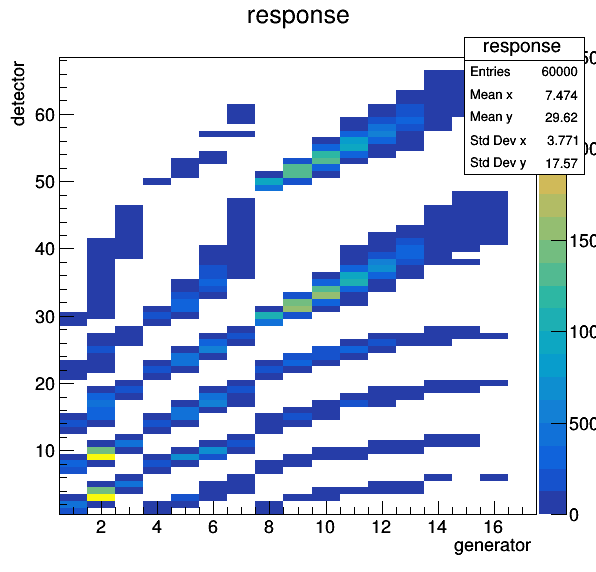

In [220]:
c = ROOT.TCanvas("c", "", 600, 600)
h_response.Draw("COLZ")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


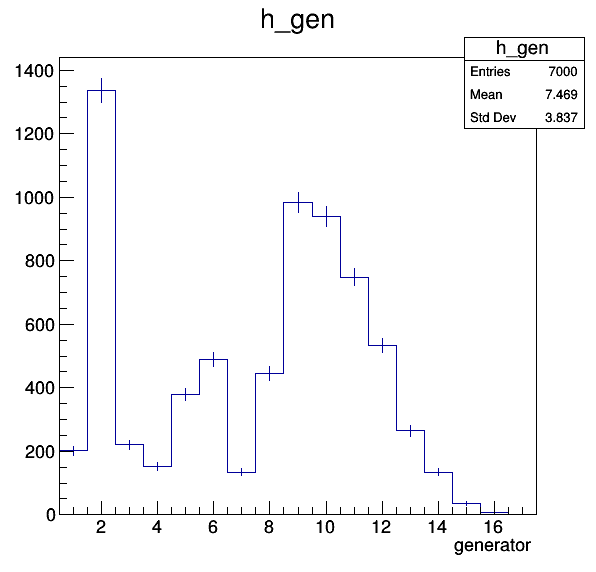

In [221]:
c = ROOT.TCanvas("c", "", 600, 600)
# Compare the x projection with 1D gen hist
proj_x = h_response.ProjectionX("_projx")
proj_x.SetLineColor(ROOT.kRed)
proj_x.SetLineStyle(2)
h_gen.Draw("hist e")
# proj_x.Draw("SAME HISTE")
# r = ROOT.TRatioPlot(h_gen, proj_x)
# r.Draw("grid")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


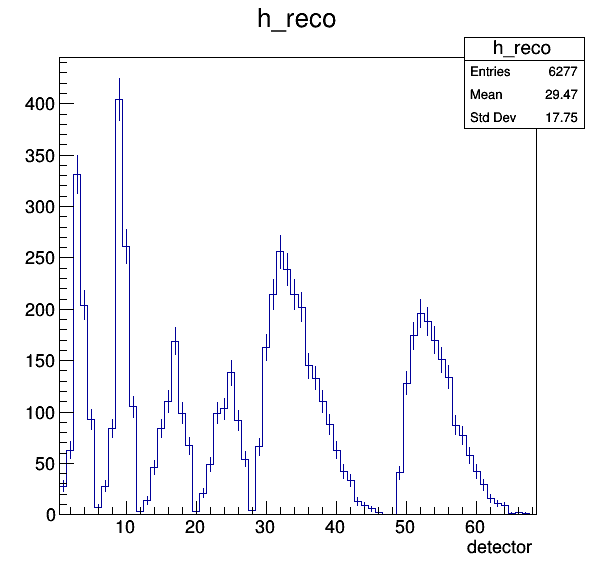

In [222]:
c = ROOT.TCanvas("c", "", 600, 600)
# compare the y projection with 1D reco hist
proj_y = h_response.ProjectionY("_projy")
proj_y.SetLineColor(ROOT.kRed)
proj_y.SetLineStyle(2)
h_reco.Draw("hist e")
# proj_y.Draw("SAME HISTE")
# r = ROOT.TRatioPlot(h_reco, proj_y)
# r.Draw("grid")
c.Draw()

In [223]:
# Setup the TUnfoldDensity object
unfolder = ROOT.TUnfoldDensity(h_response, 
                               ROOT.TUnfold.kHistMapOutputHoriz,
                               ROOT.TUnfold.kRegModeCurvature,
                               ROOT.TUnfold.kEConstraintNone,
                               ROOT.TUnfoldDensity.kDensityModeBinWidth,
                               generator_binning,
                               detector_binning
                              )

Info in <TUnfold::SetConstraint>: fConstraint=0
Warning in <TUnfold::TUnfold>: 3 output bins do not depend on the input data  0 17-18
Info in <TUnfold::TUnfold>: 68 input bins and 16 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #17 (pt_2:lha[0.9,1]:pt[75,110])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #18
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing generator regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing pt_0 regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing pt_1 regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing pt_2 regMode=3 densityMode=1 axisSteering=*[UOB]


In [224]:
# Give it the input to unfold, and do unregularised unfolding
unfolder.SetInput(h_reco)
unfolder.DoUnfold(0)
h_unfold = unfolder.GetOutput("Unfolded")

Warning in <TUnfoldDensity::SetInput>: 3/68 input bins have zero error, and are ignored.
Warning in <TUnfoldBinning::CreateHistogram>: Original binning can not be represented as THxx
Warning in <TROOT::Append>: Replacing existing TH1: Unfolded (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


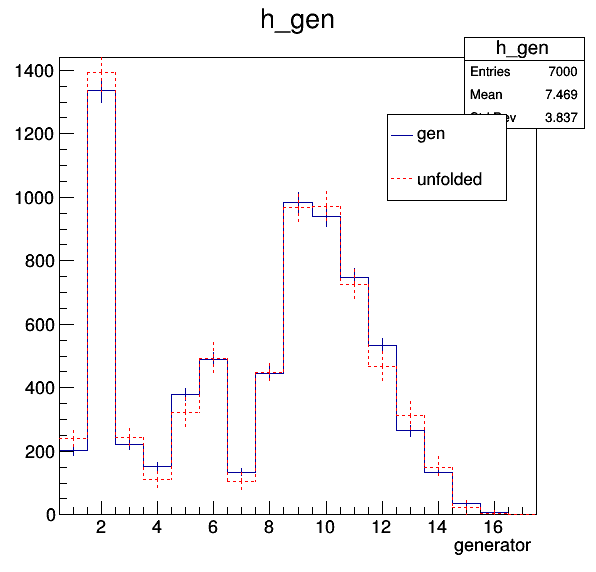

In [226]:
# Compare gen with unfolded
c = ROOT.TCanvas("c", "", 600, 600)
h_unfold.SetLineColor(ROOT.kRed)
h_unfold.SetMarkerColor(ROOT.kRed)
h_unfold.SetLineStyle(2)
h_gen.Draw("hist e")
h_unfold.Draw("hist e same")
# r = ROOT.TRatioPlot(h_gen, h_unfold)
# r.Draw("grid")
leg = ROOT.TLegend(0.65, 0.65, 0.85, 0.8)
leg.AddEntry(h_gen, "gen", "L")
leg.AddEntry(h_unfold, "unfolded", "L")
leg.Draw()
c.Draw()